In [145]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import acquire_prep as ap
import explore as ez
import modeling as mz
from env import get_connection

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

# ACQUIRE

In [146]:
# create helper function to get the necessary connection url.
def get_db_connection(database):
    return get_connection(database)

# connect to sql zillow database

url = "zillow"

    # use this query to get data    
sql_query = '''SELECT *
            FROM predictions_2017
            JOIN properties_2017 on properties_2017.parcelid = predictions_2017.parcelid
            JOIN propertylandusetype on propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid;
            '''

    # assign data to data frame
df = pd.read_sql(sql_query, get_connection(url))


In [147]:
#filter out single family residential as requested

df= df[df['propertylandusedesc'] == 'Single Family Residential']
df.shape
    

(52442, 65)

In [148]:
#filter out single family residential as requested
def narrowing(database):
    df= df[df['propertylandusedesc'] == 'Single Family Residential']
    df.shape

# Convert the 'transactiondate' column to datetime
    df['transactiondate'] = pd.to_datetime(df['transactiondate'])

# Define the start and end dates for the range
    start_date = pd.to_datetime('2017-01-01')
    end_date = pd.to_datetime('2017-12-31')

# Filter the DataFrame to keep rows within the specified date range
    df= df[(df['transactiondate'] >= start_date) & (df['transactiondate'] <= end_date)]


In [149]:
#deciding which columns to keep 
columns_to_keep = ['bathroomcnt',
                   'bedroomcnt',
                   'calculatedfinishedsquarefeet',
                   'yearbuilt',
                   'taxvaluedollarcnt']
df = df[columns_to_keep]

In [150]:
#dropping more nulls
df.dropna()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,3100.0,1998.0,1023282.0
1,1.0,2.0,1465.0,1967.0,464000.0
2,2.0,3.0,1243.0,1962.0,564778.0
3,3.0,4.0,2376.0,1970.0,145143.0
6,3.0,4.0,2962.0,1950.0,773303.0
...,...,...,...,...,...
77575,2.0,2.0,1286.0,1940.0,354621.0
77576,2.0,4.0,1612.0,1964.0,67205.0
77577,1.0,3.0,1032.0,1954.0,49546.0
77578,2.0,3.0,1762.0,1955.0,522000.0


In [151]:
#1. Rename the columns to be more readable
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area', 
                          'taxvaluedollarcnt':'tax_value', 
                          })

In [152]:
df.isna().sum()

bathrooms      0
bedrooms       0
area          82
yearbuilt    116
tax_value      1
dtype: int64

In [153]:
df=df.dropna()

In [154]:
df.isna().sum()

bathrooms    0
bedrooms     0
area         0
yearbuilt    0
tax_value    0
dtype: int64

In [155]:
### Splitting

    
train_validate, test = train_test_split(df, test_size=.2, random_state=42)
    
train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                    random_state=42)

## EXPLORE



In [156]:
X = df[['area', 'bedrooms', 'bathrooms']]
y = df['tax_value']

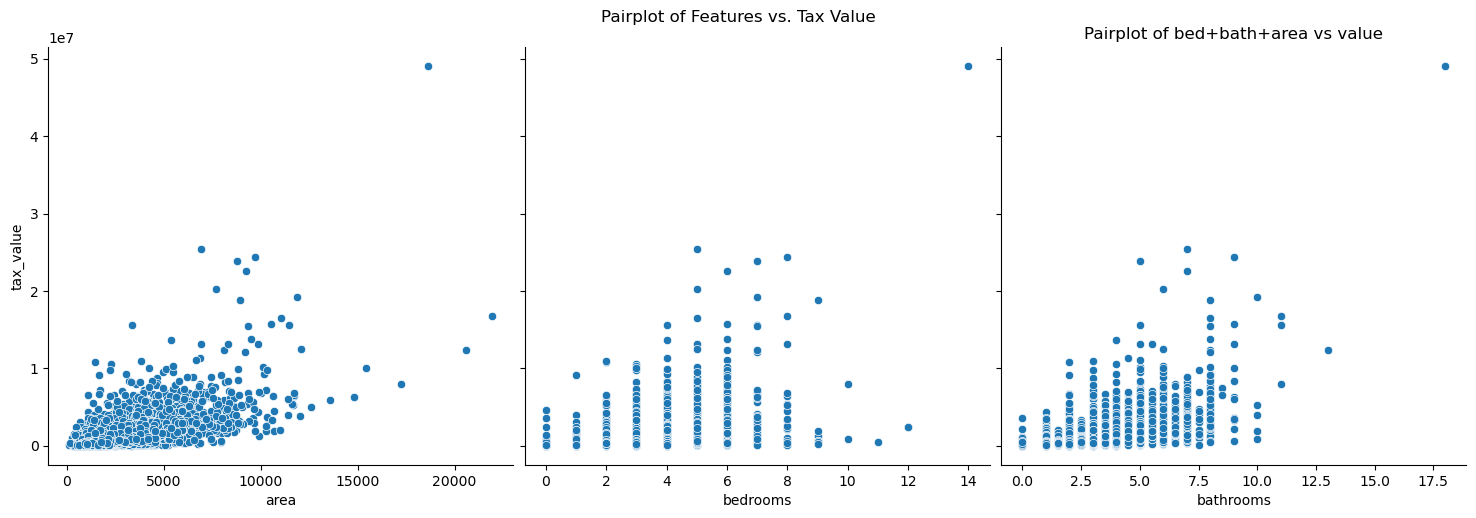

In [157]:
# Create a pairplot
sns.pairplot(df, x_vars=['area', 'bedrooms', 'bathrooms'], y_vars=['tax_value'], kind='scatter', size=5)

# Set plot labels and title
plt.xlabel("bathrooms")
plt.ylabel("Y Variable")
plt.title("Pairplot of bed+bath+area vs value")
plt.suptitle("Pairplot of Features vs. Tax Value", y=1.02)

plt.show()

### Take Aways:

1) There seem to be more transaction at the middle of the data 

2) The trend is to have a higher number of bedrooms and unequivalently low number of bathrooms

3) transaction mostly range at around 0 to 8000 area

### Hypothesis 1

1) The higher the area, the higher the tax value
    
    Null: The area are independent of the tax value
    
    Alternative: The area has a relationship with the tax value

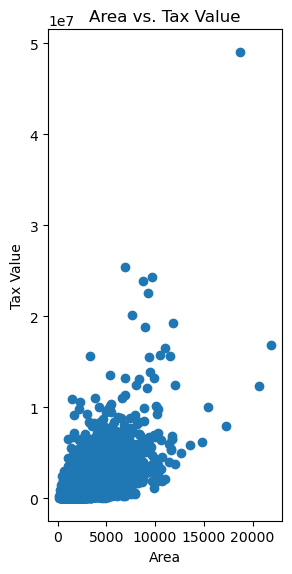

In [158]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(8, 6))

# Scatter plot for 'area' vs. 'tax_value'
plt.subplot(131)
plt.scatter(df['area'], df['tax_value'])
plt.title('Area vs. Tax Value')
plt.xlabel('Area')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

#### test

Area and tax are continuous so we will use pearson correlation

In [159]:
alpha = 0.05

In [160]:
r, p = stats.pearsonr(train.area, train.tax_value)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'pearsonsr test = {r:.4f}')

We reject the null hypothesis
pearsonsr test = 0.5982


this pearsonr value is an indication of a moderate positive linear correlation between two variables

### Hypothesis 2

2) The more the bedrooms the higher the tax value

    Null: The bedrooms are independent of the tax value
    
    Alternative: The bedrooms has a relationship with the tax value

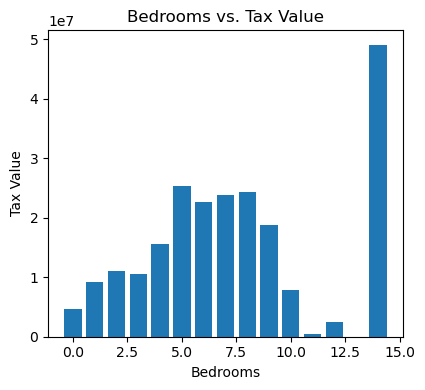

In [161]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bedrooms' vs. 'tax_value'
plt.subplot(132)
plt.bar(df['bedrooms'], df['tax_value'])
plt.title('Bedrooms vs. Tax Value')
plt.xlabel('Bedrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

## Test

Since this is categorical and continous, we need to use chi-test

In [162]:
observed = pd.crosstab(train.tax_value, train.bedrooms)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

We reject the null hypothesis
chi^2 = 276907.3886
p     = 0.0000


Both Chi2 and P value determines there is a strong relationship between bedrooms and tax values

### Hypothesis 3

3) the more the bathrooms the higher the tax value

    Null: The bathrooms are independent of the tax value
    
    Alternative: The bedrooms has a relationship with the tax value

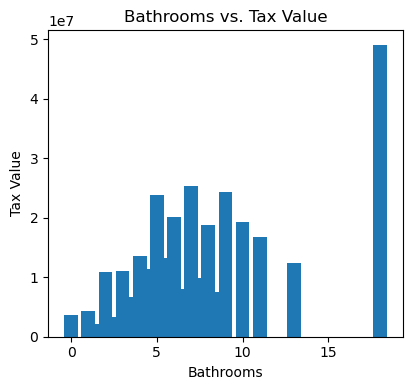

In [163]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bathrooms' vs. 'tax_value'
plt.subplot(133)
plt.bar(df['bathrooms'], df['tax_value'])
plt.title('Bathrooms vs. Tax Value')
plt.xlabel('Bathrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()



Since this is categorical and continuous, we need to use chi tet

In [164]:
observed = pd.crosstab(train.tax_value, train.bathrooms)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

We reject the null hypothesis
chi^2 = 544642.1116
p     = 0.0000


There are statistically significant relationship between the variables tested

## Could the year built be a driver?

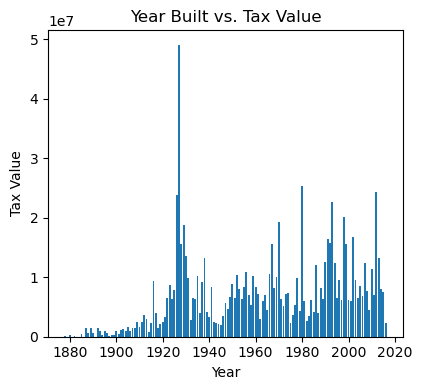

In [165]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bathrooms' vs. 'tax_value'
plt.subplot(133)
plt.bar(df['yearbuilt'], df['tax_value'])
plt.title('Year Built vs. Tax Value')
plt.xlabel('Year')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

In [166]:
r, p = stats.pearsonr(train.yearbuilt, train.tax_value)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

print(f'pearsonsr test = {r:.4f}')

We reject the null hypothesis
pearsonsr test = 0.1573


the value of pearsonr indicate a weak positive linear correlation between the two variables

# Exploration Summary

From the statistical test, we will continue to investigate bedrooms, bathrooms, area as the top 3 features 

## predictive Model

In [215]:
'''
Function drops the target of taxvaluedollarcnt column then splits data into 
predicting variables (x) and target variable (y)
''' 

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value


x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [216]:
y_train.mean()

526479.4860575446

In [217]:
y_train.median()

371159.0

In [213]:
predictions = pd.DataFrame({'Actual': train.tax_value})
predictions.head(10)

,Actual
19402,216351.0
53985,2716690.0
40101,98346.0
44713,268861.0
5296,432894.0
49550,676000.0
4200,1477503.0
42576,539346.0
53318,688629.0
53798,463539.0


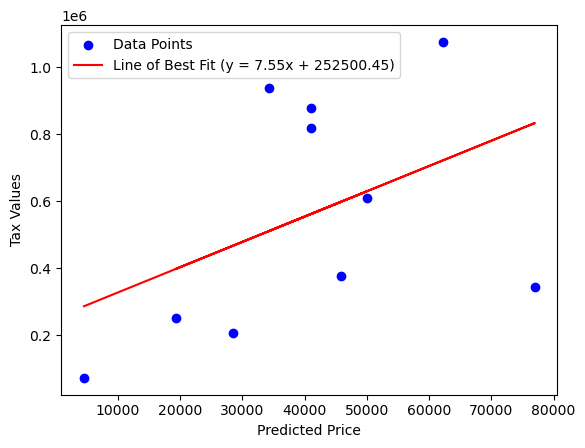

In [172]:


# Data
x = [41015, 76985, 62182, 40965, 34373, 49983, 28574, 19310, 45878, 4577]
y = [879000.0, 344893.0, 1076128.0, 819000.0, 938000.0, 610000.0, 206070.0, 253200.0, 376131.0, 73155.0]
slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = [slope * xi + intercept for xi in x]
# Create a scatter plot of the data points
plt.scatter(x, y, label='Data Points', color='blue')

# Plot the line of best fit
plt.plot(x, line_of_best_fit, label=f'Line of Best Fit (y = {slope:.2f}x + {intercept:.2f})', color='red')

# Add labels and a legend
plt.ylabel('Tax Values')
plt.xlabel('Predicted Price')
plt.legend()

# Show the plot
plt.show()


In [246]:
df['yhat_baseline'] = df['tax_value'].mean()
df.head(3)

,bathrooms,bedrooms,area,yearbuilt,tax_value,yhat_baseline,yhat
0,3.5,4.0,3100.0,1998.0,1023282.0,528071.692011,1.074334e+06
1,1.0,2.0,1465.0,1967.0,464000.0,528071.692011,4.098087e+05
2,2.0,3.0,1243.0,1962.0,564778.0,528071.692011,2.275574e+05


In [218]:
df['yhat_baseline'] = df['tax_value'].median()
df.head(3)

,bathrooms,bedrooms,area,yearbuilt,tax_value,yhat_baseline,yhat
0,3.5,4.0,3100.0,1998.0,1023282.0,373376.5,1.074334e+06
1,1.0,2.0,1465.0,1967.0,464000.0,373376.5,4.098087e+05
2,2.0,3.0,1243.0,1962.0,564778.0,373376.5,2.275574e+05


## Due to variables having different unit, I will have to scale to ensure all features have ac consistent scale

In [175]:
to_scale = ['bedrooms', 'bathrooms', 'area']
#make copies for scaling
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

#make the thing
scaler = MinMaxScaler()

#fit the thing
scaler.fit(train[to_scale])

#use the thing
train_scaled[to_scale] = scaler.transform(train[to_scale])
validate_scaled[to_scale] = scaler.transform(validate[to_scale])
test_scaled[to_scale] = scaler.transform(test[to_scale])

# Simple Linear Regression Model


In [176]:
# generate parameters, i.e. create model
ols_model = LinearRegression().fit(df[['area','bathrooms','bedrooms']], df.tax_value)

# compute predictions and add to original dataframe
df['yhat'] = ols_model.predict(df[['area','bathrooms','bedrooms']])

df.head(10)

,bathrooms,bedrooms,area,yearbuilt,tax_value,yhat_baseline,yhat
0,3.5,4.0,3100.0,1998.0,1023282.0,528071.692011,1.074334e+06
1,1.0,2.0,1465.0,1967.0,464000.0,528071.692011,4.098087e+05
2,2.0,3.0,1243.0,1962.0,564778.0,528071.692011,2.275574e+05
3,3.0,4.0,2376.0,1970.0,145143.0,528071.692011,6.915815e+05
6,3.0,4.0,2962.0,1950.0,773303.0,528071.692011,9.710777e+05
7,1.0,2.0,738.0,1922.0,218552.0,528071.692011,6.306173e+04
8,3.0,4.0,3039.0,1970.0,220583.0,528071.692011,1.007803e+06
10,3.0,4.0,2540.0,1999.0,430108.0,528071.692011,7.698023e+05
13,2.5,3.0,1340.0,1980.0,319668.0,528071.692011,3.112588e+05
15,2.5,3.0,1371.0,2004.0,198054.0,528071.692011,3.260445e+05


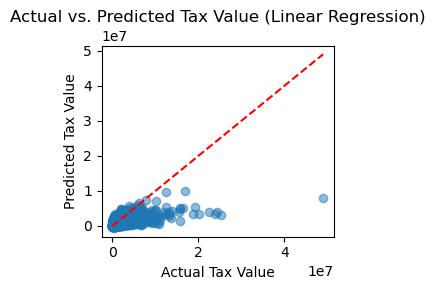

In [177]:

# Assuming you have already created the 'yhat' column in your DataFrame

# Create a scatterplot of actual vs. predicted values
plt.figure(figsize=(3, 3))
plt.scatter(df['tax_value'], df['yhat'], alpha=0.5)
plt.xlabel('Actual Tax Value')
plt.ylabel('Predicted Tax Value')
plt.title('Actual vs. Predicted Tax Value (Linear Regression)')

# Add a 45-degree reference line for comparison
plt.plot([df['tax_value'].min(), df['tax_value'].max()], [df['tax_value'].min(), df['tax_value'].max()], color='red', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()


In [178]:

'''
Function takes the predicted variable (x) and target variable (y)
fits them to the simple linear regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

lm_model = LinearRegression().fit(x_train, y_train)
train['lm_predictions'] = lm_model.predict(x_train)
validate['lm_predictions'] = lm_model.predict(x_validate)

lm_co = lm_model.coef_
lm_int = lm_model.intercept_

simp_co = pd.Series(lm_model.coef_, index=x_train.columns).sort_values()


In [179]:
simp_co

bedrooms    -152936.356428
area            496.983028
bathrooms     66309.898855
dtype: float64

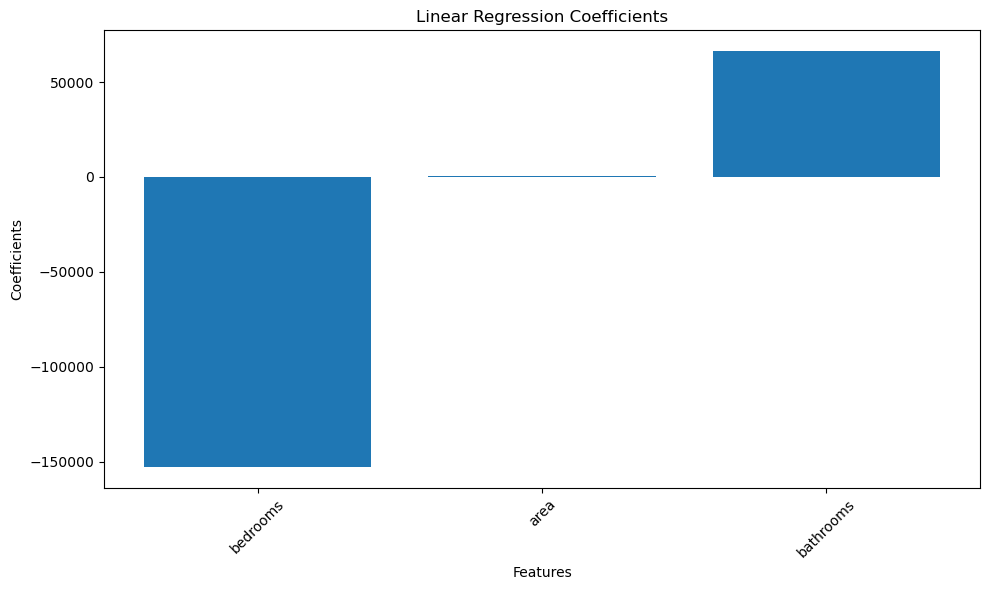

In [180]:


# Assuming you have already calculated lm_co and sorted it as simp_co

# Create a bar plot of the coefficients
plt.figure(figsize=(10, 6))
plt.bar(simp_co.index, simp_co.values)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


In [181]:
'''
Function takes the predicted variable (x) and target variable (y)
fits them to the lasso lars regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

lars = LassoLars(alpha=1).fit(x_train, y_train)
train['lars_predictions'] = lars.predict(x_train)
validate['lars_predictions'] = lars.predict(x_validate)

lars_co = pd.Series(lars.coef_, index=x_train.columns).sort_values()


In [182]:
lars_co

bedrooms    -152933.588812
area            496.985364
bathrooms     66305.315321
dtype: float64

In [183]:
'''
Takes the predicted variable (x) and target variable (y)
fits them to the generalized linear regression model and computes the predictions 
and then adds them to the dataframe  
''' 
x_train = train[['area','bathrooms','bedrooms']]
y_train = train.tax_value

x_validate = validate[['area','bathrooms','bedrooms']]
y_validate = validate.tax_value

glm_model = TweedieRegressor(power=0, alpha=1).fit(x_train, y_train)
train['glm_predictions'] = glm_model.predict(x_train)
validate['glm_predictions'] = glm_model.predict(x_validate)

glm_co = pd.Series(glm_model.coef_, index=x_train.columns).sort_values()

In [184]:
glm_co

bedrooms    -48721.313428
area           486.900446
bathrooms     6392.773850
dtype: float64

In [185]:
## Evalute the Models

In [219]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the baseline predictions
y = train.tax_value
baseline = np.repeat(y.median(), len(y))

MSE = mean_squared_error(y, baseline)
SSE = MSE * len(y)
RMSE = MSE**.5

In [220]:
MSE

626881380900.624

In [221]:
SSE

1.8366997579007384e+16

In [222]:
RMSE

791758.4106914331

In [190]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the lars predictions
y = train.tax_value
yhat = train.lars_predictions
MSE = mean_squared_error(y, yhat)
SSE = MSE * len(y)
RMSE = MSE**.5

In [191]:
MSE

375556242515.4246

In [192]:
SSE

1.1003422349459426e+16

In [193]:
RMSE

612826.4375134485

In [194]:
# Calculating the
    # Sum of Squared Errors
    # Mean Squared Errors
    # Root of Mean Squared Errors
# for the lars predictions
y = train.tax_value
yhat = train.glm_predictions
MSE = mean_squared_error(y, yhat)
SSE = MSE * len(y)
RMSE = MSE**.5

In [195]:
MSE

381016777821.07446

In [196]:
SSE

1.116341057337966e+16

In [197]:
RMSE

617265.5650699093

### Further evaluation

In [227]:
# Create Dataframes for visual comparison
y_train = pd.DataFrame(train.tax_value)
y_validate = pd.DataFrame(validate.tax_value)
y_test = pd.DataFrame(test.tax_value)

In [228]:
# Place our baseline predictions in the new dataframe
taxVal_pred_mean = train.tax_value.mean()
y_train['taxVal_pred_mean'] = taxVal_pred_mean
y_validate['taxVal_pred_mean'] = taxVal_pred_mean

In [229]:
# RMSE of baseline predictions on train & validate
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.taxVal_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value,
                                   y_validate.taxVal_pred_mean) ** (1/2)

In [230]:
# Here we can compare the baseline results from the training 
# sample set versus the validate sample set
# not very much difference in the errors
print("RMSE Baseline Results\nTrain/Sample Set: ", round(rmse_train, 2), 
      "\nValidate/Sample Set: ", round(rmse_validate, 2))

RMSE Baseline Results
Train/Sample Set:  776374.22 
Validate/Sample Set:  709997.44


In [231]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [232]:
# Create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# Nab those safe baseline predictions from earlier
metric_df = make_metric_df(y_validate.tax_value,
                           y_validate.taxVal_pred_mean,
                           'mean_baseline',
                          metric_df)
# Voila
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,709997.439268,-2.220446e-16


This high RMSE values indicate my model has a large errors and does not match with the actual value

In [233]:
# Adding the validate results for the Ols model 
metric_df = metric_df.append({
    'model': 'SimpleLinear', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.lm_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.lm_predictions)}, ignore_index=True)
# Voila
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,7.099974e+05,-2.220446e-16
1,SimpleLinear,2.987674e+11,4.073339e-01


In [234]:
# Adding the validate results for the LassoLars model
metric_df = metric_df.append({
    'model': 'LassoLars', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.lars_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.lars_predictions)}, ignore_index=True)
# Voila
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,7.099974e+05,-2.220446e-16
1,SimpleLinear,2.987674e+11,4.073339e-01
2,LassoLars,2.987673e+11,4.073340e-01


In [235]:
# Adding the validate results for the Tweedie model
metric_df = metric_df.append({
    'model': 'GeneralizedLinear', 
    'RMSE_validate': mean_squared_error(validate.tax_value, validate.glm_predictions),
    'r^2_validate': explained_variance_score(validate.tax_value, validate.glm_predictions)}, ignore_index=True)
# Voila
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,7.099974e+05,-2.220446e-16
1,SimpleLinear,2.987674e+11,4.073339e-01
2,LassoLars,2.987673e+11,4.073340e-01
3,GeneralizedLinear,3.029314e+11,3.990762e-01


# SelectKBest

In [243]:
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(x_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train.iloc[:,feature_mask].columns.tolist()

In [244]:
rfe_feature

['bedrooms', 'lm_predictions']

## Modeling Take Away

SimpleLinear and LassoLars is very similar, but to lower the error score, i will have to use the simple Linear

In [245]:

# Create and fit the Simple Linear model
simple_linear_model = LinearRegression().fit(x_test, y_test)

# Make predictions on the test set
y_test['simple_linear_predictions'] = simple_linear_model.predict(x_test)

# Calculate RMSE for the Simple Linear model on the test set
rmse_test = mean_squared_error(y_test.tax_value, y_test.simple_linear_predictions) ** 0.5

print("RMSE for Simple Linear Model Test-Sample Performance: ", rmse_test)


RMSE for Simple Linear Model Test-Sample Performance:  546840.6876845366


In [247]:
df.yearbuilt.min()

1878.0